Device in use: cuda
Original image shape: (474, 474, 3) Type: uint8


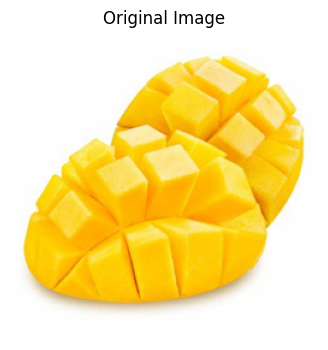

Iterations: 100%|██████████| 16/16 [00:00<00:00, 18.10it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Cl

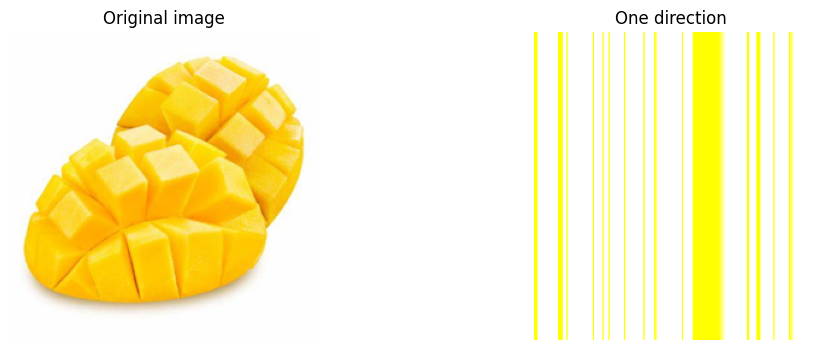

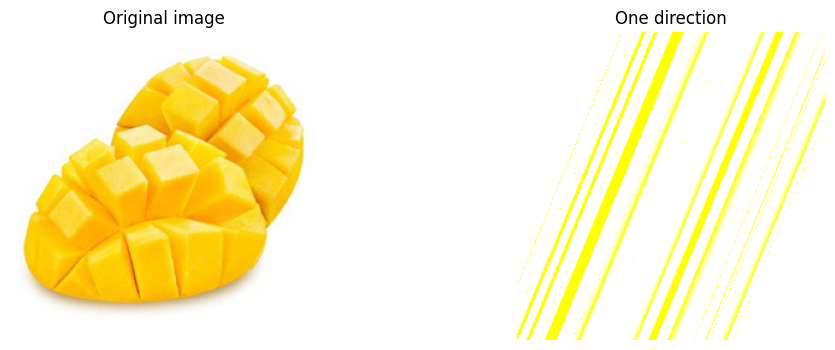

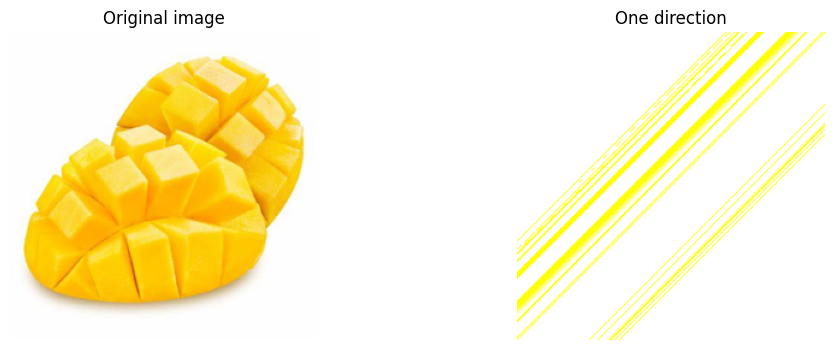

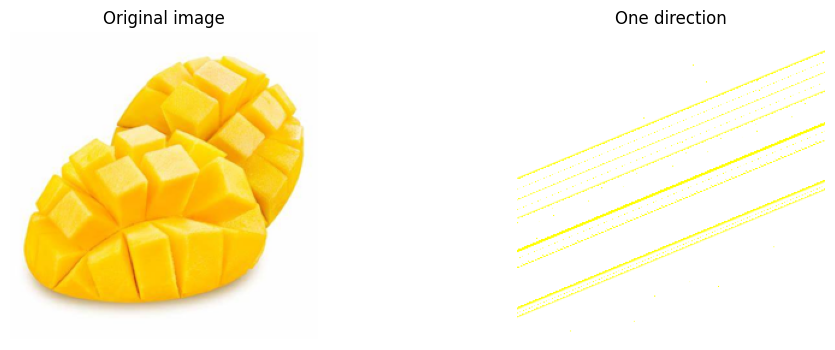

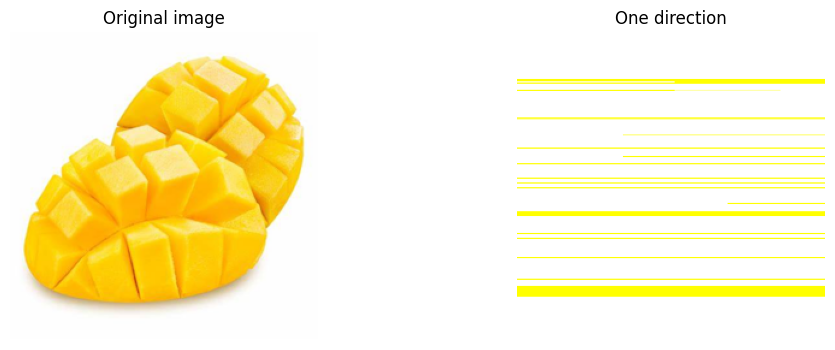

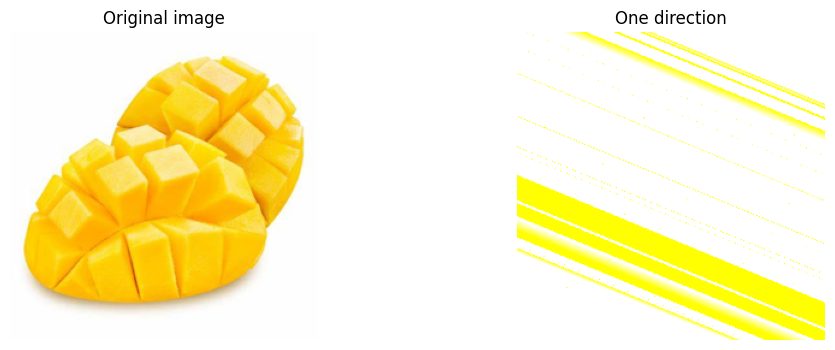

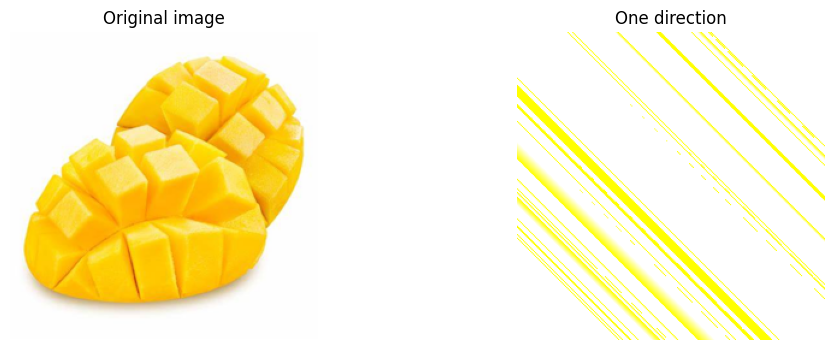

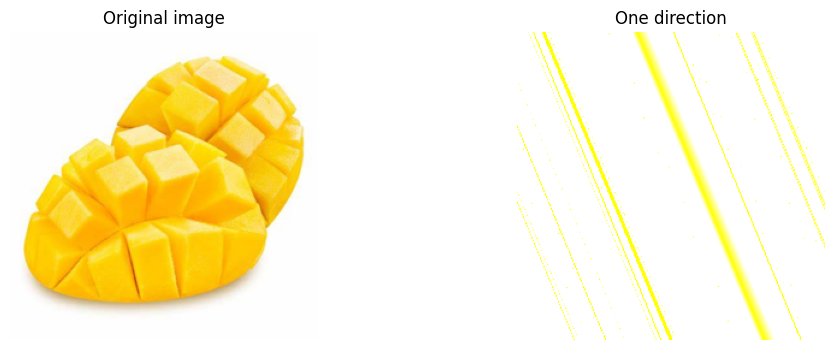

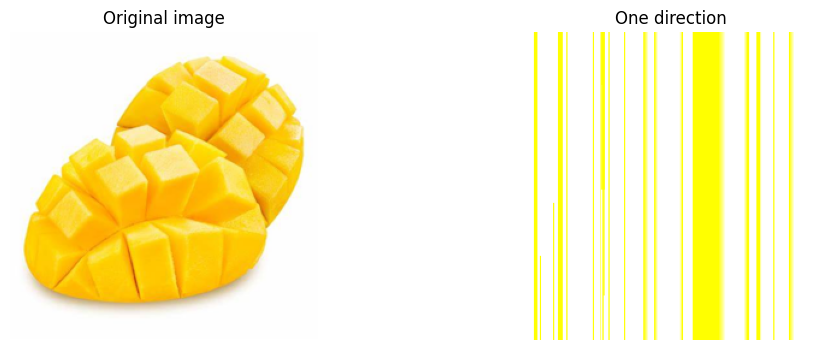

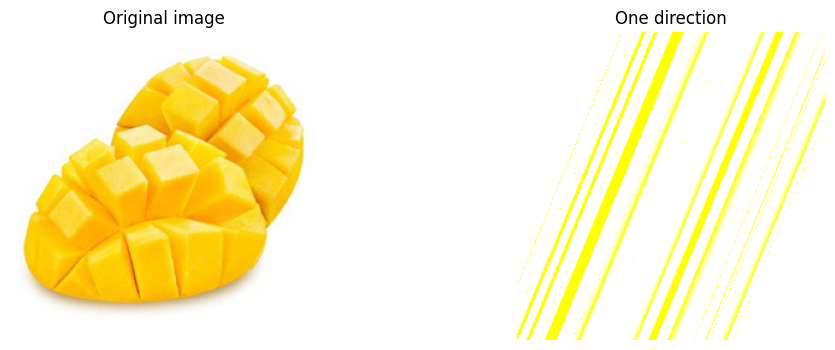

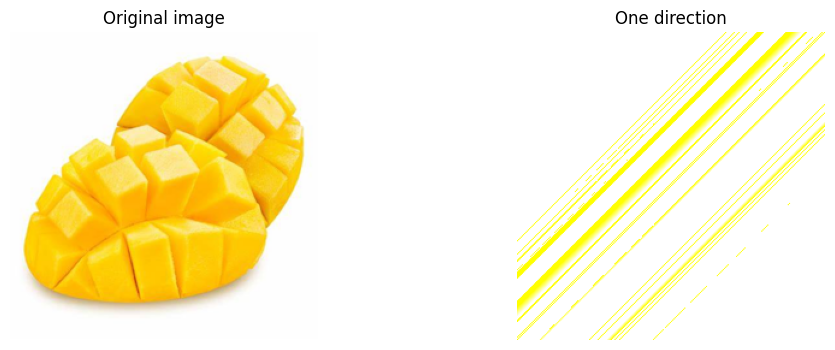

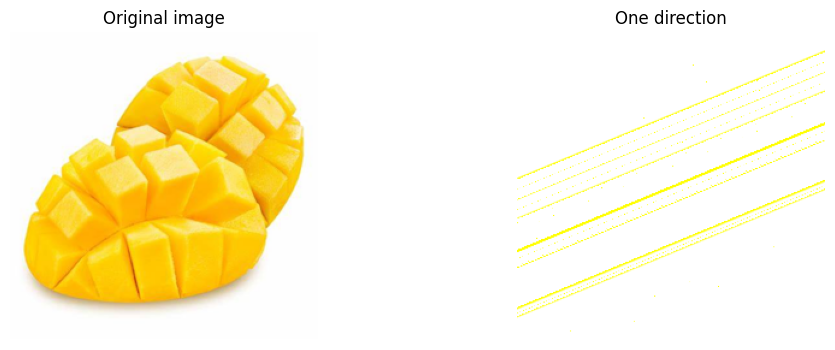

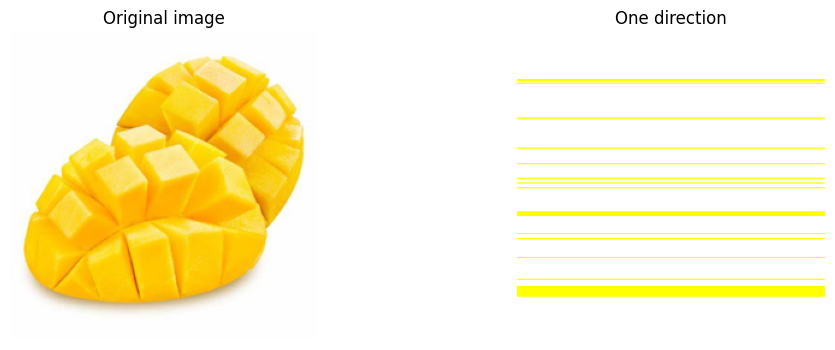

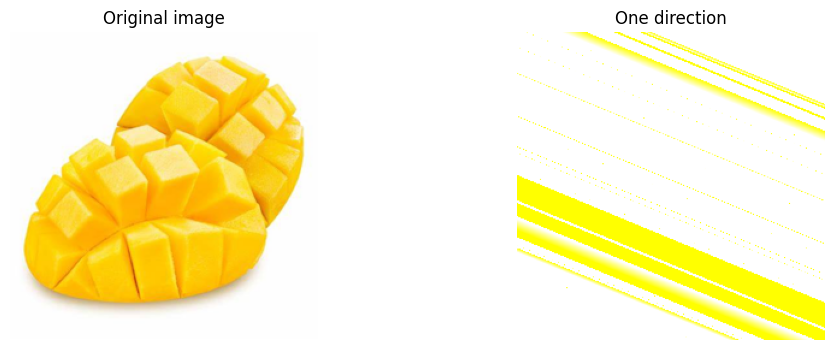

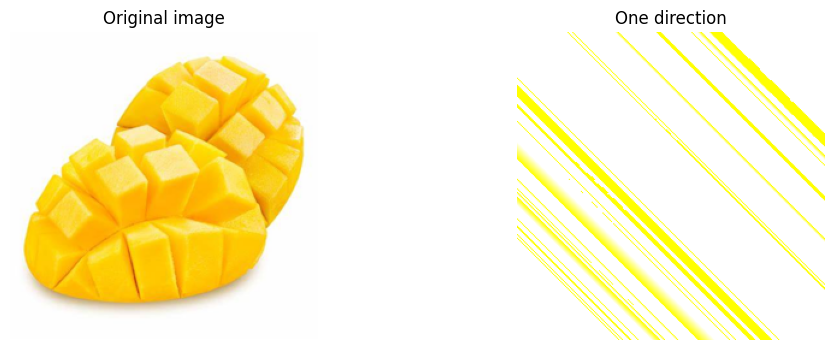

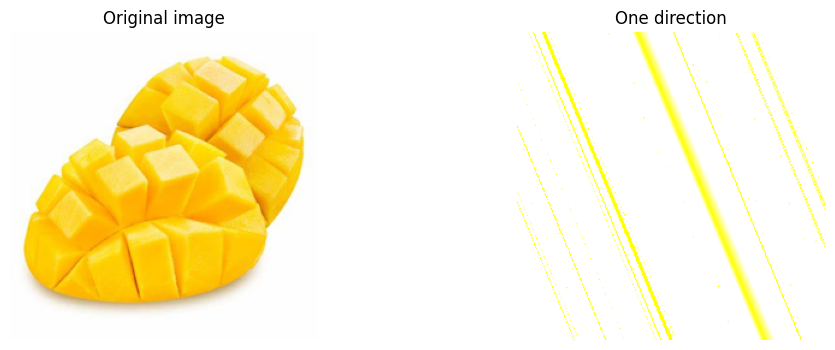

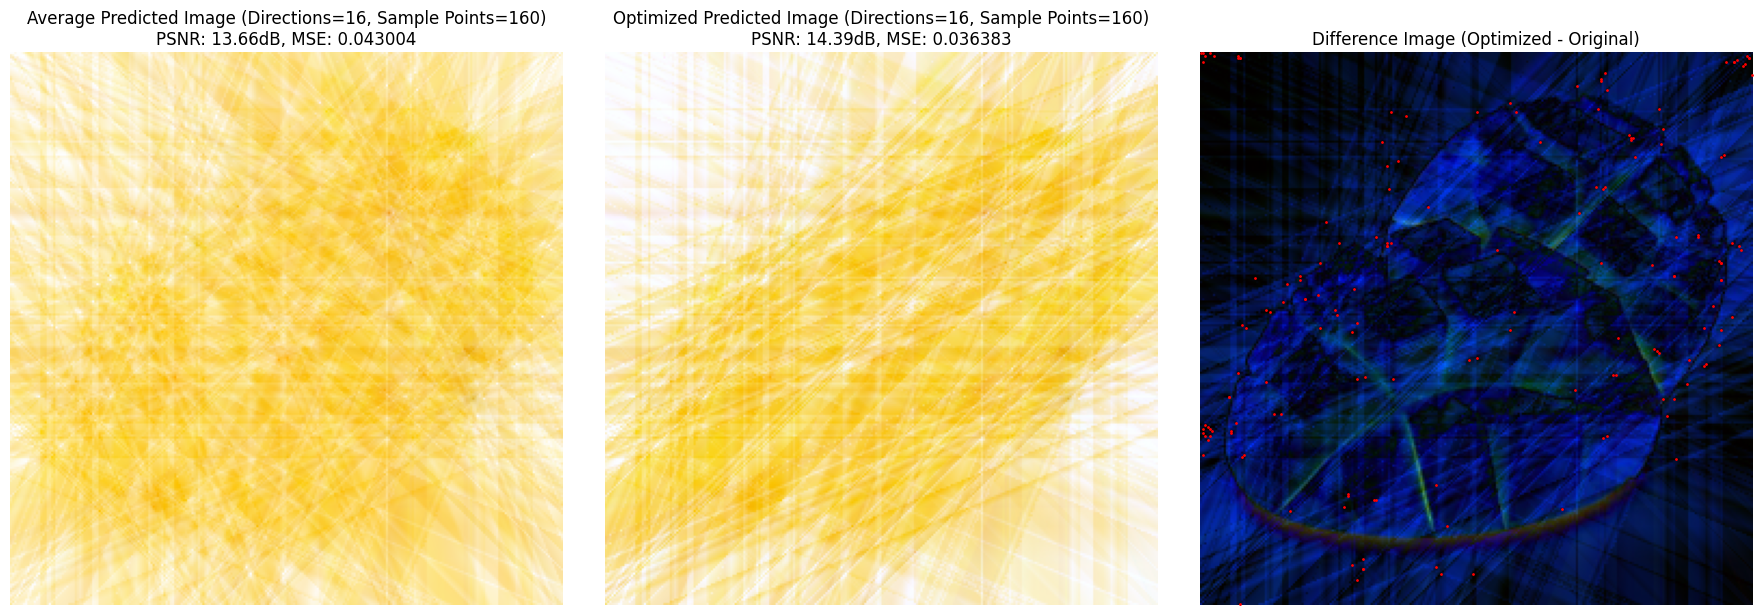

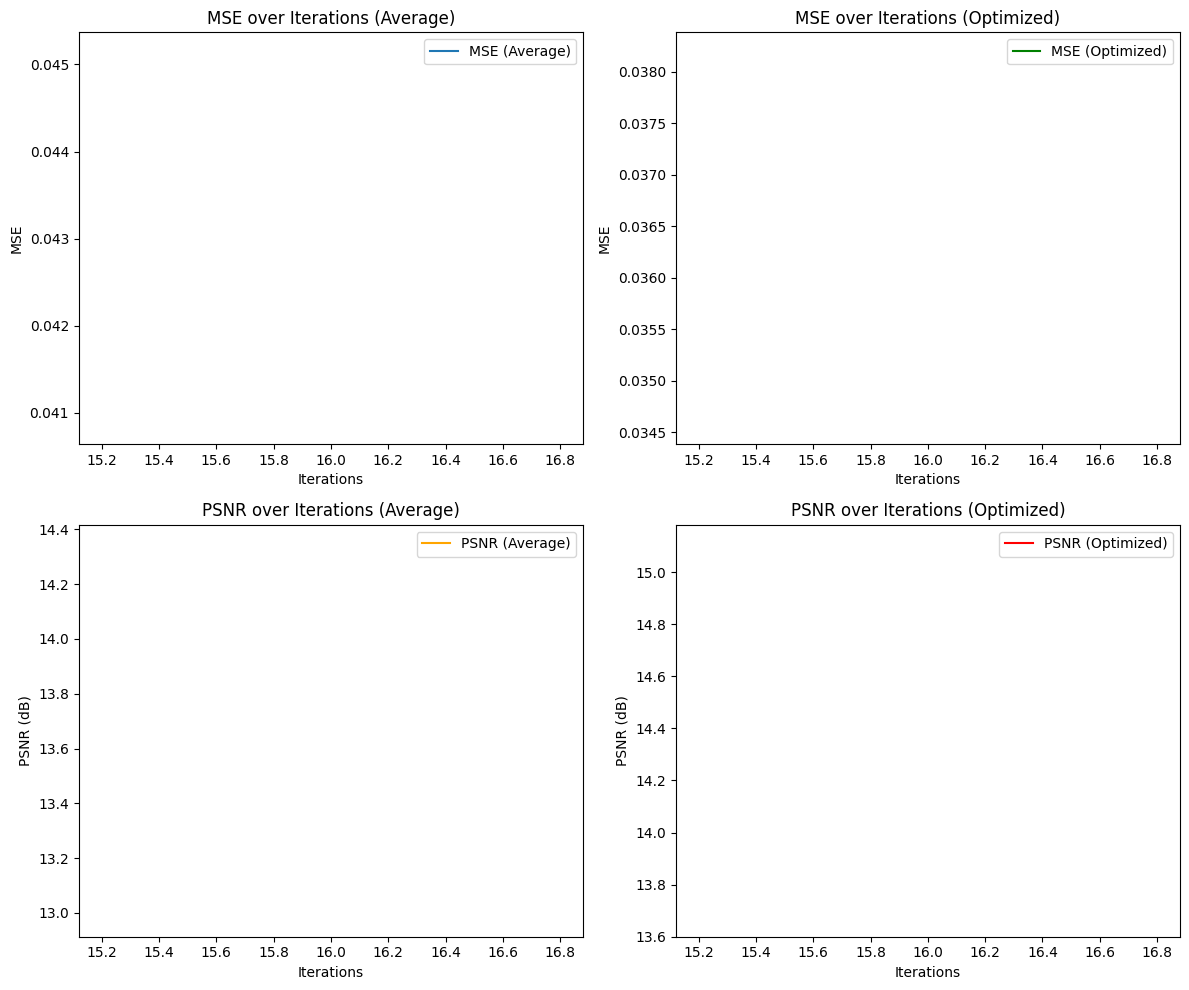

: 

In [ ]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from tqdm import tqdm
from PIL import Image

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in use: {device}")

# Define functions to calculate MSE and PSNR
def calculate_metrics(original, reconstructed):
    mse_value = mean_squared_error(original, reconstructed)
    psnr_value = peak_signal_noise_ratio(original, reconstructed, data_range=original.max() - original.min())
    return mse_value, psnr_value

# Load image
image_url = "3.jpg"
image_original = imageio.imread(image_url)
print("Original image shape:", image_original.shape, "Type:", image_original.dtype)

image_pil = Image.fromarray(image_original)
image_original = np.array(image_pil.resize((256, 256)))

# Display the original image
plt.figure(figsize=(6, 4))
plt.imshow(image_original)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Convert to [0,1]
image = image_original.astype(np.float32)
if image.max() > 1.0:
    image /= 255.0
height, width, channels = image.shape

image_tensor = torch.tensor(image, dtype=torch.float32, device=device)

# Define functions
def generate_random_directions(num_directions):
    angles = np.linspace(0, 2 * np.pi, num_directions, endpoint=False, dtype=np.float32)
    angles = torch.tensor(angles, dtype=torch.float32, device=device)
    directions = [(torch.cos(angle), torch.sin(angle)) for angle in angles]
    return directions

def calculate_coordinates(Px, Py, dx, dy):
    return dx * Px + dy * Py

def build_1d_curve(Px, Py, values, dx, dy):
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    sorted_coords, sorted_indices = torch.sort(coordinates)
    sorted_values = values[sorted_indices]

    # Process each channel separately
    curves = []
    for c in range(3):
        channel_values = sorted_values[:, c]
        unique_coords, inverse_indices, counts = torch.unique(
            sorted_coords, return_inverse=True, return_counts=True
        )
        sum_values = torch.zeros_like(unique_coords)
        sum_values = sum_values.scatter_add(0, inverse_indices, channel_values)
        mean_values = sum_values / counts.float()
        curves.append(torch.stack((unique_coords, mean_values), dim=1))
    return curves  # Returns curves for each channel

def predict_image(curves, dx, dy, width, height):
    Py, Px = torch.meshgrid(
        torch.arange(height, device=device),
        torch.arange(width, device=device),
        indexing='ij'
    )
    Px = Px.flatten()
    Py = Py.flatten()
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    predicted_values = []
    for c in range(3):
        curve = curves[c]
        pv = torch_interp_lerp(coordinates, curve[:, 0], curve[:, 1])
        predicted_values.append(pv)
    predicted_values = torch.stack(predicted_values, dim=1)
    predicted_values = torch.clamp(predicted_values, 0, 255)
    predicted_image = predicted_values.reshape((height, width, 3))
    return predicted_image

def downsample_pixels(Px, Py, sample_size=5000):
    total_pixels = len(Px)
    if total_pixels <= sample_size:
        return Px, Py
    else:
        sampled_indices = torch.randint(0, total_pixels, (sample_size,), device=device)
        return Px[sampled_indices], Py[sampled_indices]

def select_initial_sampling_points(num_points, width, height):
    x0 = torch.randint(0, width, (num_points,), device=device)
    y0 = torch.randint(0, height, (num_points,), device=device)
    return x0, y0

def torch_interp_lerp(x, xp, fp):
    indices = torch.searchsorted(xp, x)
    indices = torch.clamp(indices, 1, len(xp) - 1)

    x0 = xp[indices - 1]
    x1 = xp[indices]
    y0 = fp[indices - 1]
    y1 = fp[indices]

    weight = (x - x0) / (x1 - x0 + 1e-8)  # Avoid division by zero
    return torch.lerp(y0, y1, weight)

# Parameters for Analysis
# num_directions_list = [16, 128,512,1024]  # Different number of directions to test
# num_iterations_list = [512,1024]

num_directions_list = [16]  # Different number of directions to test
num_iterations_list = [16]
# Threshold for combinations
threshold = 16 * 960000

# Lists to store MSE and PSNR values for plotting
mse_history = []
psnr_history = []
iteration_history = []
mse_opt_history = []
psnr_opt_history = []

# Loop over combinations
for num_directions in num_directions_list:
    for num_iterations in num_iterations_list:
        # Generate Random Directions
        if num_directions * num_iterations > threshold:
            continue
        height, width, channels = image_tensor.shape
        directions = generate_random_directions(num_directions)
        initial_sample_size = 1
        sampled_Px, sampled_Py = select_initial_sampling_points(initial_sample_size, width, height)
        sampled_values = (image_tensor * 255.0)[sampled_Py, sampled_Px]

        Py, Px = torch.meshgrid(
            torch.arange(height, device=device),
            torch.arange(width, device=device),
            indexing='ij'
        )
        Px = Px.flatten()
        Py = Py.flatten()

        for t in tqdm(range(num_iterations), desc="Iterations"):
            downsampled_Px, downsampled_Py = downsample_pixels(Px, Py)
            av = (image_tensor * 255.0)[downsampled_Py, downsampled_Px]
            combined_predicted_values = torch.zeros_like(av, dtype=torch.float32, device=device)

            for idx in range(num_directions):
                dx, dy = directions[idx]
                curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
                pv_channels = []
                for c in range(channels):
                    curve = curves[c]
                    pv = torch_interp_lerp(
                        calculate_coordinates(downsampled_Px, downsampled_Py, dx, dy),
                        curve[:, 0], curve[:, 1]
                    )
                    pv_channels.append(pv)
                pv = torch.stack(pv_channels, dim=1)
                combined_predicted_values += pv

            combined_predicted_values /= num_directions
            downsampled_error = torch.max(torch.abs(av - combined_predicted_values), dim=1).values

            top_k_indices = torch.argsort(downsampled_error)[-10:]
            error_y = downsampled_Py[top_k_indices]
            error_x = downsampled_Px[top_k_indices]

            sampled_Px = torch.cat([sampled_Px, error_x])
            sampled_Py = torch.cat([sampled_Py, error_y])
            sampled_values = torch.cat([sampled_values, (image_tensor * 255.0)[error_y, error_x]])

        # Reconstruct images from predictions without storing all predicted images
        # Compute the average predicted image
        final_predicted_image_sum = torch.zeros((height, width, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            predicted_image = predict_image(curves, dx, dy, width, height)
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            axes[0].imshow(image_original)
            axes[0].set_title(f'Original image')
            axes[0].axis('off')
            axes[1].imshow(predicted_image.cpu())
            axes[1].set_title(f'One direction')
            axes[1].axis('off')
            final_predicted_image_sum += predicted_image
        final_predicted_image_avg = final_predicted_image_sum / num_directions
        final_predicted_image_avg = torch.clamp(final_predicted_image_avg, 0, 255)
        reconstructed2_avg = final_predicted_image_avg.cpu().numpy() / 255.0

        # Evaluation metrics
        mse2_avg, psnr2_avg = calculate_metrics(image, reconstructed2_avg)
        mse_history.append(mse2_avg)
        psnr_history.append(psnr2_avg)
        iteration_history.append(num_iterations)

        # Optimized predicted image using least squares without storing all predicted images
        # Sample a subset of pixels for the least squares problem
        num_samples = 10000
        sample_indices = torch.randint(0, height * width, (num_samples,), device=device)
        sampled_Px_ls = (sample_indices % width).long()
        sampled_Py_ls = (sample_indices // width).long()
        original_values = (image_tensor * 255.0)[sampled_Py_ls, sampled_Px_ls]

        # Initialize X matrix for least squares
        X = torch.zeros((num_samples, num_directions, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            for c in range(channels):
                curve = curves[c]
                predicted_values = torch_interp_lerp(
                    calculate_coordinates(sampled_Px_ls, sampled_Py_ls, dx, dy),
                    curve[:, 0], curve[:, 1]
                )
                X[:, idx, c] = predicted_values

        # Solve least squares problem for each channel
        w_opt = torch.zeros((num_directions, channels), device=device)
        for c in range(channels):
            X_channel = X[:, :, c]
            y_channel = original_values[:, c]
            solution = torch.linalg.lstsq(X_channel, y_channel.unsqueeze(1))
            w_opt_channel = solution.solution.squeeze()
            w_opt[:, c] = w_opt_channel

        # Reconstruct the final predicted image using optimized weights
        final_predicted_image_opt = torch.zeros((height, width, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            predicted_image = predict_image(curves, dx, dy, width, height)
            for c in range(channels):
                final_predicted_image_opt[:, :, c] += w_opt[idx, c] * predicted_image[:, :, c]

        final_predicted_image_opt = torch.clamp(final_predicted_image_opt, 0, 255)
        reconstructed2_opt = final_predicted_image_opt.cpu().numpy() / 255.0

        # Optimized evaluation metrics
        mse2_opt, psnr2_opt = calculate_metrics(image, reconstructed2_opt)
        mse_opt_history.append(mse2_opt)
        psnr_opt_history.append(psnr2_opt)

        # Difference Image (Optimized - Original)
        difference_image = np.abs(reconstructed2_opt - image)

        # Plotting Results
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        axes[0].imshow(final_predicted_image_avg.cpu().numpy() / 255.0)
        axes[0].set_title(f'Average Predicted Image (Directions={num_directions}, Sample Points={num_iterations*10})\nPSNR: {psnr2_avg:.2f}dB, MSE: {mse2_avg:.6f}')
        axes[0].axis('off')

        axes[1].imshow(reconstructed2_opt)
        axes[1].set_title(f'Optimized Predicted Image (Directions={num_directions}, Sample Points={num_iterations*10})\nPSNR: {psnr2_opt:.2f}dB, MSE: {mse2_opt:.6f}')
        axes[1].axis('off')

        axes[2].imshow(difference_image)
        axes[2].scatter(sampled_Px.cpu(), sampled_Py.cpu(), c='red', s=1, label=f'Sample Points')
        axes[2].set_title('Difference Image (Optimized - Original)')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

# Plotting MSE and PSNR
plt.figure(figsize=(12, 10))

# Plot MSE
plt.subplot(2, 2, 1)
plt.plot(iteration_history, mse_history, label='MSE (Average)')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('MSE over Iterations (Average)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(iteration_history, mse_opt_history, label='MSE (Optimized)', color='green')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('MSE over Iterations (Optimized)')
plt.legend()

# Plot PSNR
plt.subplot(2, 2, 3)
plt.plot(iteration_history, psnr_history, label='PSNR (Average)', color='orange')
plt.xlabel('Iterations')
plt.ylabel('PSNR (dB)')
plt.title('PSNR over Iterations (Average)')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(iteration_history, psnr_opt_history, label='PSNR (Optimized)', color='red')
plt.xlabel('Iterations')
plt.ylabel('PSNR (dB)')
plt.title('PSNR over Iterations (Optimized)')
plt.legend()

plt.tight_layout()
plt.show()


Device in use: cuda
Original image shape: (484, 780, 3) Type: uint8


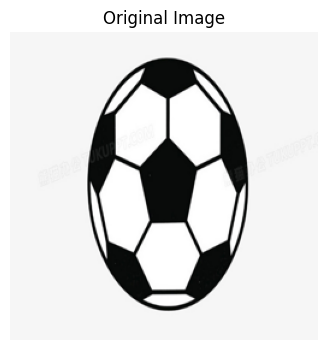

Iterations: 100%|██████████| 1024/1024 [06:16<00:00,  2.72it/s]


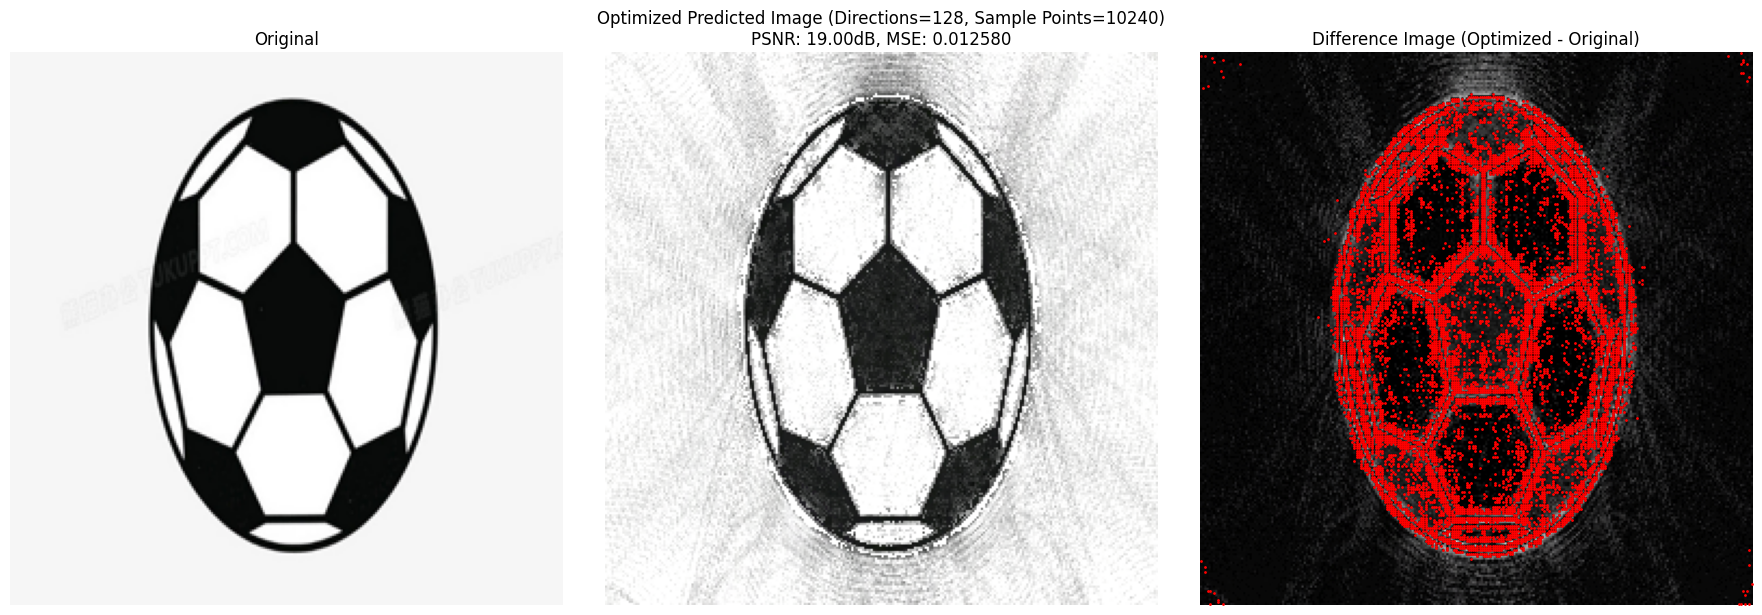

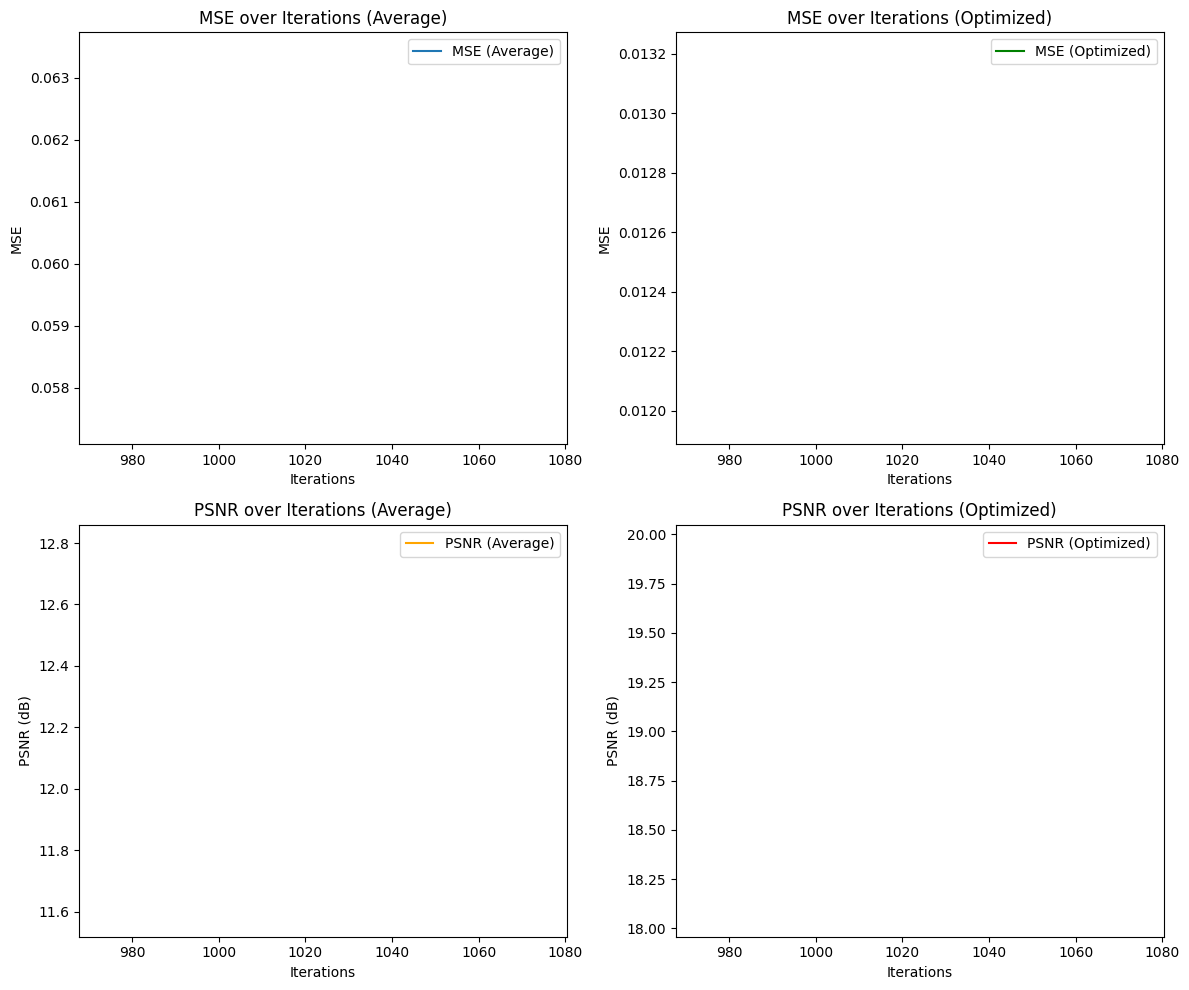

In [2]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from tqdm import tqdm
from PIL import Image

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in use: {device}")

# Define functions to calculate MSE and PSNR
def calculate_metrics(original, reconstructed):
    mse_value = mean_squared_error(original, reconstructed)
    psnr_value = peak_signal_noise_ratio(original, reconstructed, data_range=original.max() - original.min())
    return mse_value, psnr_value

# Load image
image_url = "4.jpg"
image_original = imageio.imread(image_url)
print("Original image shape:", image_original.shape, "Type:", image_original.dtype)

image_pil = Image.fromarray(image_original)
image_original = np.array(image_pil.resize((256, 256)))

# Display the original image
plt.figure(figsize=(6, 4))
plt.imshow(image_original)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Convert to [0,1]
image = image_original.astype(np.float32)
if image.max() > 1.0:
    image /= 255.0
height, width, channels = image.shape

image_tensor = torch.tensor(image, dtype=torch.float32, device=device)

# Define functions
def generate_random_directions(num_directions):
    angles = np.linspace(0, 2 * np.pi, num_directions, endpoint=False, dtype=np.float32)
    angles = torch.tensor(angles, dtype=torch.float32, device=device)
    directions = [(torch.cos(angle), torch.sin(angle)) for angle in angles]
    return directions

def calculate_coordinates(Px, Py, dx, dy):
    return dx * Px + dy * Py

def build_1d_curve(Px, Py, values, dx, dy):
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    sorted_coords, sorted_indices = torch.sort(coordinates)
    sorted_values = values[sorted_indices]

    # Process each channel separately
    curves = []
    for c in range(3):
        channel_values = sorted_values[:, c]
        unique_coords, inverse_indices, counts = torch.unique(
            sorted_coords, return_inverse=True, return_counts=True
        )
        sum_values = torch.zeros_like(unique_coords)
        sum_values = sum_values.scatter_add(0, inverse_indices, channel_values)
        mean_values = sum_values / counts.float()
        curves.append(torch.stack((unique_coords, mean_values), dim=1))
    return curves  # Returns curves for each channel

def predict_image(curves, dx, dy, width, height):
    Py, Px = torch.meshgrid(
        torch.arange(height, device=device),
        torch.arange(width, device=device),
        indexing='ij'
    )
    Px = Px.flatten()
    Py = Py.flatten()
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    predicted_values = []
    for c in range(3):
        curve = curves[c]
        pv = torch_interp_lerp(coordinates, curve[:, 0], curve[:, 1])
        predicted_values.append(pv)
    predicted_values = torch.stack(predicted_values, dim=1)
    predicted_values = torch.clamp(predicted_values, 0, 255)
    predicted_image = predicted_values.reshape((height, width, 3))
    return predicted_image

def downsample_pixels(Px, Py, sample_size=5000):
    total_pixels = len(Px)
    if total_pixels <= sample_size:
        return Px, Py
    else:
        sampled_indices = torch.randint(0, total_pixels, (sample_size,), device=device)
        return Px[sampled_indices], Py[sampled_indices]

def select_initial_sampling_points(num_points, width, height):
    x0 = torch.randint(0, width, (num_points,), device=device)
    y0 = torch.randint(0, height, (num_points,), device=device)
    return x0, y0

def torch_interp_lerp(x, xp, fp):
    indices = torch.searchsorted(xp, x)
    indices = torch.clamp(indices, 1, len(xp) - 1)

    x0 = xp[indices - 1]
    x1 = xp[indices]
    y0 = fp[indices - 1]
    y1 = fp[indices]

    weight = (x - x0) / (x1 - x0 + 1e-8)  # Avoid division by zero
    return torch.lerp(y0, y1, weight)

# Parameters for Analysis
# num_directions_list = [16, 128,512,1024]  # Different number of directions to test
# num_iterations_list = [512,1024]

num_directions_list = [128]  # Different number of directions to test
num_iterations_list = [1024]
# Threshold for combinations
threshold = 16 * 960000

# Lists to store MSE and PSNR values for plotting
mse_history = []
psnr_history = []
iteration_history = []
mse_opt_history = []
psnr_opt_history = []

# Loop over combinations
for num_directions in num_directions_list:
    for num_iterations in num_iterations_list:
        # Generate Random Directions
        if num_directions * num_iterations > threshold:
            continue
        height, width, channels = image_tensor.shape
        directions = generate_random_directions(num_directions)
        initial_sample_size = 1
        sampled_Px, sampled_Py = select_initial_sampling_points(initial_sample_size, width, height)
        sampled_values = (image_tensor * 255.0)[sampled_Py, sampled_Px]

        Py, Px = torch.meshgrid(
            torch.arange(height, device=device),
            torch.arange(width, device=device),
            indexing='ij'
        )
        Px = Px.flatten()
        Py = Py.flatten()

        for t in tqdm(range(num_iterations), desc="Iterations"):
            downsampled_Px, downsampled_Py = downsample_pixels(Px, Py)
            av = (image_tensor * 255.0)[downsampled_Py, downsampled_Px]
            combined_predicted_values = torch.zeros_like(av, dtype=torch.float32, device=device)

            for idx in range(num_directions):
                dx, dy = directions[idx]
                curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
                pv_channels = []
                for c in range(channels):
                    curve = curves[c]
                    pv = torch_interp_lerp(
                        calculate_coordinates(downsampled_Px, downsampled_Py, dx, dy),
                        curve[:, 0], curve[:, 1]
                    )
                    pv_channels.append(pv)
                pv = torch.stack(pv_channels, dim=1)
                combined_predicted_values += pv

            combined_predicted_values /= num_directions
            downsampled_error = torch.max(torch.abs(av - combined_predicted_values), dim=1).values

            top_k_indices = torch.argsort(downsampled_error)[-10:]
            error_y = downsampled_Py[top_k_indices]
            error_x = downsampled_Px[top_k_indices]

            sampled_Px = torch.cat([sampled_Px, error_x])
            sampled_Py = torch.cat([sampled_Py, error_y])
            sampled_values = torch.cat([sampled_values, (image_tensor * 255.0)[error_y, error_x]])

        # Reconstruct images from predictions without storing all predicted images
        # Compute the average predicted image
        final_predicted_image_sum = torch.zeros((height, width, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            predicted_image = predict_image(curves, dx, dy, width, height)
            final_predicted_image_sum += predicted_image
        final_predicted_image_avg = final_predicted_image_sum / num_directions
        final_predicted_image_avg = torch.clamp(final_predicted_image_avg, 0, 255)
        reconstructed2_avg = final_predicted_image_avg.cpu().numpy() / 255.0

        # Evaluation metrics
        mse2_avg, psnr2_avg = calculate_metrics(image, reconstructed2_avg)
        mse_history.append(mse2_avg)
        psnr_history.append(psnr2_avg)
        iteration_history.append(num_iterations)

        # Optimized predicted image using least squares without storing all predicted images
        # Sample a subset of pixels for the least squares problem
        num_samples = 10000
        sample_indices = torch.randint(0, height * width, (num_samples,), device=device)
        sampled_Px_ls = (sample_indices % width).long()
        sampled_Py_ls = (sample_indices // width).long()
        original_values = (image_tensor * 255.0)[sampled_Py_ls, sampled_Px_ls]

        # Initialize X matrix for least squares
        X = torch.zeros((num_samples, num_directions, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            for c in range(channels):
                curve = curves[c]
                predicted_values = torch_interp_lerp(
                    calculate_coordinates(sampled_Px_ls, sampled_Py_ls, dx, dy),
                    curve[:, 0], curve[:, 1]
                )
                X[:, idx, c] = predicted_values

        # Solve least squares problem for each channel
        w_opt = torch.zeros((num_directions, channels), device=device)
        for c in range(channels):
            X_channel = X[:, :, c]
            y_channel = original_values[:, c]
            solution = torch.linalg.lstsq(X_channel, y_channel.unsqueeze(1))
            w_opt_channel = solution.solution.squeeze()
            w_opt[:, c] = w_opt_channel

        # Reconstruct the final predicted image using optimized weights
        final_predicted_image_opt = torch.zeros((height, width, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            predicted_image = predict_image(curves, dx, dy, width, height)
            for c in range(channels):
                final_predicted_image_opt[:, :, c] += w_opt[idx, c] * predicted_image[:, :, c]

        final_predicted_image_opt = torch.clamp(final_predicted_image_opt, 0, 255)
        reconstructed2_opt = final_predicted_image_opt.cpu().numpy() / 255.0

        # Optimized evaluation metrics
        mse2_opt, psnr2_opt = calculate_metrics(image, reconstructed2_opt)
        mse_opt_history.append(mse2_opt)
        psnr_opt_history.append(psnr2_opt)

        # Difference Image (Optimized - Original)
        difference_image = np.abs(reconstructed2_opt - image)

        # Plotting Results
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        axes[0].imshow(image_original)
        axes[0].set_title(f'Original')
        axes[0].axis('off')

        axes[1].imshow(reconstructed2_opt)
        axes[1].set_title(f'Optimized Predicted Image (Directions={num_directions}, Sample Points={num_iterations*10})\nPSNR: {psnr2_opt:.2f}dB, MSE: {mse2_opt:.6f}')
        axes[1].axis('off')

        axes[2].imshow(difference_image)
        axes[2].scatter(sampled_Px.cpu(), sampled_Py.cpu(), c='red', s=1, label=f'Sample Points')
        axes[2].set_title('Difference Image (Optimized - Original)')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

# Plotting MSE and PSNR
plt.figure(figsize=(12, 10))

# Plot MSE
plt.subplot(2, 2, 1)
plt.plot(iteration_history, mse_history, label='MSE (Average)')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('MSE over Iterations (Average)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(iteration_history, mse_opt_history, label='MSE (Optimized)', color='green')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('MSE over Iterations (Optimized)')
plt.legend()

# Plot PSNR
plt.subplot(2, 2, 3)
plt.plot(iteration_history, psnr_history, label='PSNR (Average)', color='orange')
plt.xlabel('Iterations')
plt.ylabel('PSNR (dB)')
plt.title('PSNR over Iterations (Average)')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(iteration_history, psnr_opt_history, label='PSNR (Optimized)', color='red')
plt.xlabel('Iterations')
plt.ylabel('PSNR (dB)')
plt.title('PSNR over Iterations (Optimized)')
plt.legend()

plt.tight_layout()
plt.show()


Device in use: cuda
Original image shape: (799, 1199, 3) Type: uint8


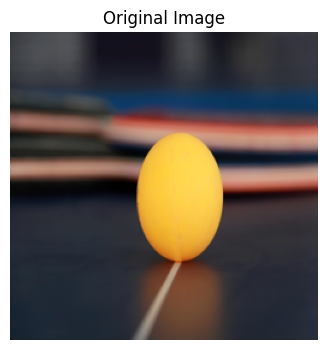

Iterations: 100%|██████████| 1024/1024 [06:22<00:00,  2.68it/s]


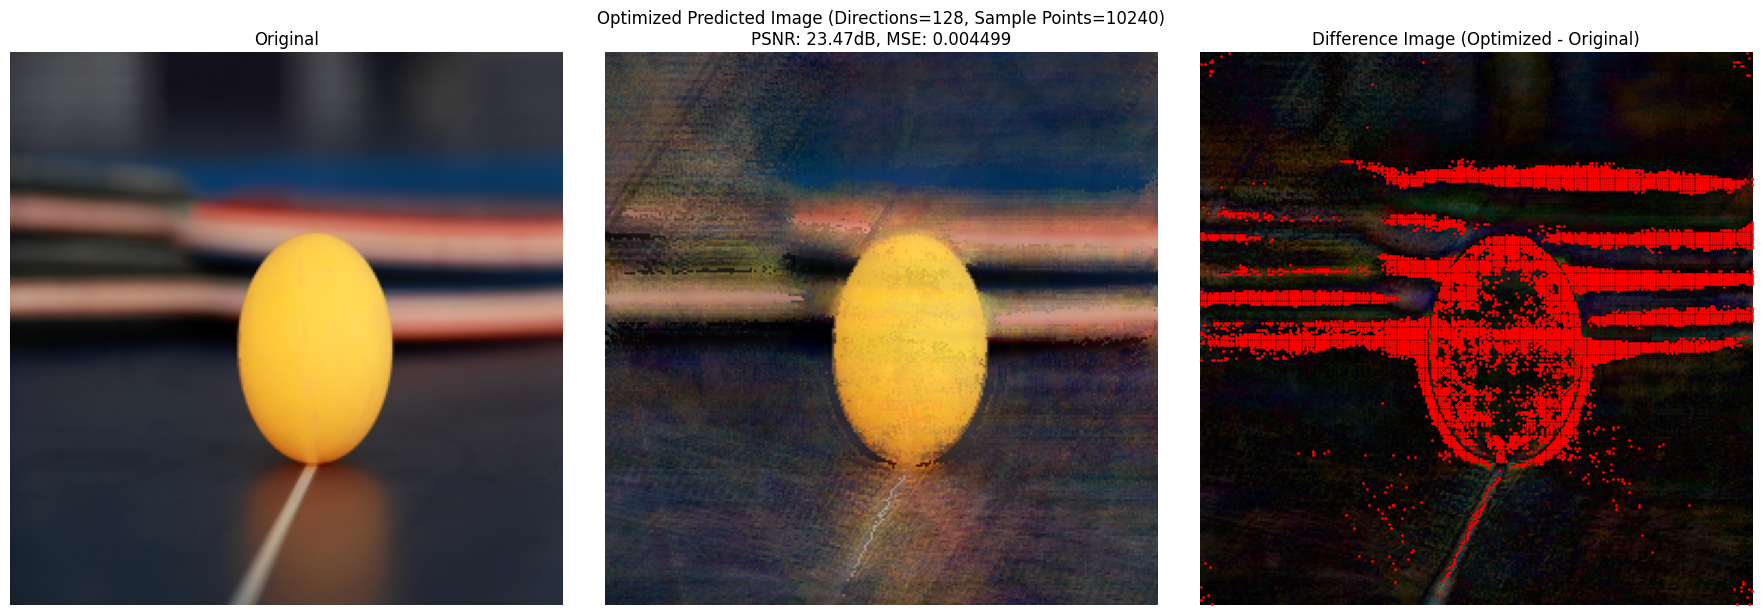

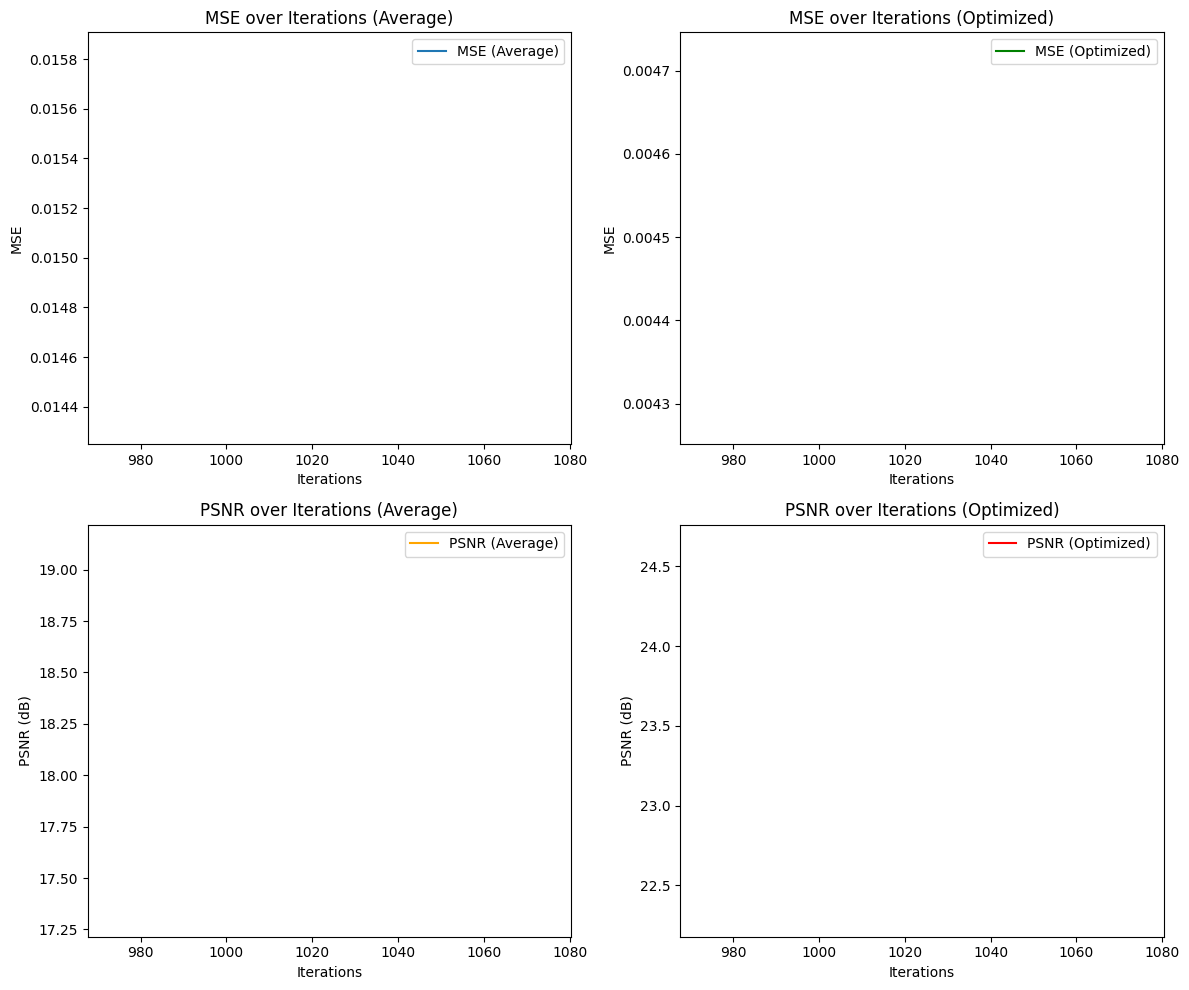

In [3]:

import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import time
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio
from tqdm import tqdm
from PIL import Image

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in use: {device}")

# Define functions to calculate MSE and PSNR
def calculate_metrics(original, reconstructed):
    mse_value = mean_squared_error(original, reconstructed)
    psnr_value = peak_signal_noise_ratio(original, reconstructed, data_range=original.max() - original.min())
    return mse_value, psnr_value

# Load image
image_url = "5.jpg"
image_original = imageio.imread(image_url)
print("Original image shape:", image_original.shape, "Type:", image_original.dtype)

image_pil = Image.fromarray(image_original)
image_original = np.array(image_pil.resize((256, 256)))

# Display the original image
plt.figure(figsize=(6, 4))
plt.imshow(image_original)
plt.title('Original Image')
plt.axis('off')
plt.show()

# Convert to [0,1]
image = image_original.astype(np.float32)
if image.max() > 1.0:
    image /= 255.0
height, width, channels = image.shape

image_tensor = torch.tensor(image, dtype=torch.float32, device=device)

# Define functions
def generate_random_directions(num_directions):
    angles = np.linspace(0, 2 * np.pi, num_directions, endpoint=False, dtype=np.float32)
    angles = torch.tensor(angles, dtype=torch.float32, device=device)
    directions = [(torch.cos(angle), torch.sin(angle)) for angle in angles]
    return directions

def calculate_coordinates(Px, Py, dx, dy):
    return dx * Px + dy * Py

def build_1d_curve(Px, Py, values, dx, dy):
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    sorted_coords, sorted_indices = torch.sort(coordinates)
    sorted_values = values[sorted_indices]

    # Process each channel separately
    curves = []
    for c in range(3):
        channel_values = sorted_values[:, c]
        unique_coords, inverse_indices, counts = torch.unique(
            sorted_coords, return_inverse=True, return_counts=True
        )
        sum_values = torch.zeros_like(unique_coords)
        sum_values = sum_values.scatter_add(0, inverse_indices, channel_values)
        mean_values = sum_values / counts.float()
        curves.append(torch.stack((unique_coords, mean_values), dim=1))
    return curves  # Returns curves for each channel

def predict_image(curves, dx, dy, width, height):
    Py, Px = torch.meshgrid(
        torch.arange(height, device=device),
        torch.arange(width, device=device),
        indexing='ij'
    )
    Px = Px.flatten()
    Py = Py.flatten()
    coordinates = calculate_coordinates(Px, Py, dx, dy)
    predicted_values = []
    for c in range(3):
        curve = curves[c]
        pv = torch_interp_lerp(coordinates, curve[:, 0], curve[:, 1])
        predicted_values.append(pv)
    predicted_values = torch.stack(predicted_values, dim=1)
    predicted_values = torch.clamp(predicted_values, 0, 255)
    predicted_image = predicted_values.reshape((height, width, 3))
    return predicted_image

def downsample_pixels(Px, Py, sample_size=5000):
    total_pixels = len(Px)
    if total_pixels <= sample_size:
        return Px, Py
    else:
        sampled_indices = torch.randint(0, total_pixels, (sample_size,), device=device)
        return Px[sampled_indices], Py[sampled_indices]

def select_initial_sampling_points(num_points, width, height):
    x0 = torch.randint(0, width, (num_points,), device=device)
    y0 = torch.randint(0, height, (num_points,), device=device)
    return x0, y0

def torch_interp_lerp(x, xp, fp):
    indices = torch.searchsorted(xp, x)
    indices = torch.clamp(indices, 1, len(xp) - 1)

    x0 = xp[indices - 1]
    x1 = xp[indices]
    y0 = fp[indices - 1]
    y1 = fp[indices]

    weight = (x - x0) / (x1 - x0 + 1e-8)  # Avoid division by zero
    return torch.lerp(y0, y1, weight)

# Parameters for Analysis
# num_directions_list = [16, 128,512,1024]  # Different number of directions to test
# num_iterations_list = [512,1024]

num_directions_list = [128]  # Different number of directions to test
num_iterations_list = [1024]
# Threshold for combinations
threshold = 16 * 960000

# Lists to store MSE and PSNR values for plotting
mse_history = []
psnr_history = []
iteration_history = []
mse_opt_history = []
psnr_opt_history = []

# Loop over combinations
for num_directions in num_directions_list:
    for num_iterations in num_iterations_list:
        # Generate Random Directions
        if num_directions * num_iterations > threshold:
            continue
        height, width, channels = image_tensor.shape
        directions = generate_random_directions(num_directions)
        initial_sample_size = 1
        sampled_Px, sampled_Py = select_initial_sampling_points(initial_sample_size, width, height)
        sampled_values = (image_tensor * 255.0)[sampled_Py, sampled_Px]

        Py, Px = torch.meshgrid(
            torch.arange(height, device=device),
            torch.arange(width, device=device),
            indexing='ij'
        )
        Px = Px.flatten()
        Py = Py.flatten()

        for t in tqdm(range(num_iterations), desc="Iterations"):
            downsampled_Px, downsampled_Py = downsample_pixels(Px, Py)
            av = (image_tensor * 255.0)[downsampled_Py, downsampled_Px]
            combined_predicted_values = torch.zeros_like(av, dtype=torch.float32, device=device)

            for idx in range(num_directions):
                dx, dy = directions[idx]
                curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
                pv_channels = []
                for c in range(channels):
                    curve = curves[c]
                    pv = torch_interp_lerp(
                        calculate_coordinates(downsampled_Px, downsampled_Py, dx, dy),
                        curve[:, 0], curve[:, 1]
                    )
                    pv_channels.append(pv)
                pv = torch.stack(pv_channels, dim=1)
                combined_predicted_values += pv

            combined_predicted_values /= num_directions
            downsampled_error = torch.max(torch.abs(av - combined_predicted_values), dim=1).values

            top_k_indices = torch.argsort(downsampled_error)[-10:]
            error_y = downsampled_Py[top_k_indices]
            error_x = downsampled_Px[top_k_indices]

            sampled_Px = torch.cat([sampled_Px, error_x])
            sampled_Py = torch.cat([sampled_Py, error_y])
            sampled_values = torch.cat([sampled_values, (image_tensor * 255.0)[error_y, error_x]])

        # Reconstruct images from predictions without storing all predicted images
        # Compute the average predicted image
        final_predicted_image_sum = torch.zeros((height, width, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            predicted_image = predict_image(curves, dx, dy, width, height)
            final_predicted_image_sum += predicted_image
        final_predicted_image_avg = final_predicted_image_sum / num_directions
        final_predicted_image_avg = torch.clamp(final_predicted_image_avg, 0, 255)
        reconstructed2_avg = final_predicted_image_avg.cpu().numpy() / 255.0

        # Evaluation metrics
        mse2_avg, psnr2_avg = calculate_metrics(image, reconstructed2_avg)
        mse_history.append(mse2_avg)
        psnr_history.append(psnr2_avg)
        iteration_history.append(num_iterations)

        # Optimized predicted image using least squares without storing all predicted images
        # Sample a subset of pixels for the least squares problem
        num_samples = 10000
        sample_indices = torch.randint(0, height * width, (num_samples,), device=device)
        sampled_Px_ls = (sample_indices % width).long()
        sampled_Py_ls = (sample_indices // width).long()
        original_values = (image_tensor * 255.0)[sampled_Py_ls, sampled_Px_ls]

        # Initialize X matrix for least squares
        X = torch.zeros((num_samples, num_directions, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            for c in range(channels):
                curve = curves[c]
                predicted_values = torch_interp_lerp(
                    calculate_coordinates(sampled_Px_ls, sampled_Py_ls, dx, dy),
                    curve[:, 0], curve[:, 1]
                )
                X[:, idx, c] = predicted_values

        # Solve least squares problem for each channel
        w_opt = torch.zeros((num_directions, channels), device=device)
        for c in range(channels):
            X_channel = X[:, :, c]
            y_channel = original_values[:, c]
            solution = torch.linalg.lstsq(X_channel, y_channel.unsqueeze(1))
            w_opt_channel = solution.solution.squeeze()
            w_opt[:, c] = w_opt_channel

        # Reconstruct the final predicted image using optimized weights
        final_predicted_image_opt = torch.zeros((height, width, channels), device=device)
        for idx in range(num_directions):
            dx, dy = directions[idx]
            curves = build_1d_curve(sampled_Px, sampled_Py, sampled_values, dx, dy)
            predicted_image = predict_image(curves, dx, dy, width, height)
            for c in range(channels):
                final_predicted_image_opt[:, :, c] += w_opt[idx, c] * predicted_image[:, :, c]

        final_predicted_image_opt = torch.clamp(final_predicted_image_opt, 0, 255)
        reconstructed2_opt = final_predicted_image_opt.cpu().numpy() / 255.0

        # Optimized evaluation metrics
        mse2_opt, psnr2_opt = calculate_metrics(image, reconstructed2_opt)
        mse_opt_history.append(mse2_opt)
        psnr_opt_history.append(psnr2_opt)

        # Difference Image (Optimized - Original)
        difference_image = np.abs(reconstructed2_opt - image)

        # Plotting Results
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        axes[0].imshow(image_original)
        axes[0].set_title(f'Original')
        axes[0].axis('off')

        axes[1].imshow(reconstructed2_opt)
        axes[1].set_title(f'Optimized Predicted Image (Directions={num_directions}, Sample Points={num_iterations*10})\nPSNR: {psnr2_opt:.2f}dB, MSE: {mse2_opt:.6f}')
        axes[1].axis('off')

        axes[2].imshow(difference_image)
        axes[2].scatter(sampled_Px.cpu(), sampled_Py.cpu(), c='red', s=1, label=f'Sample Points')
        axes[2].set_title('Difference Image (Optimized - Original)')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

# Plotting MSE and PSNR
plt.figure(figsize=(12, 10))

# Plot MSE
plt.subplot(2, 2, 1)
plt.plot(iteration_history, mse_history, label='MSE (Average)')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('MSE over Iterations (Average)')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(iteration_history, mse_opt_history, label='MSE (Optimized)', color='green')
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.title('MSE over Iterations (Optimized)')
plt.legend()

# Plot PSNR
plt.subplot(2, 2, 3)
plt.plot(iteration_history, psnr_history, label='PSNR (Average)', color='orange')
plt.xlabel('Iterations')
plt.ylabel('PSNR (dB)')
plt.title('PSNR over Iterations (Average)')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(iteration_history, psnr_opt_history, label='PSNR (Optimized)', color='red')
plt.xlabel('Iterations')
plt.ylabel('PSNR (dB)')
plt.title('PSNR over Iterations (Optimized)')
plt.legend()

plt.tight_layout()
plt.show()
